# Customer Churn Prediction
This notebook focuses on creating a baseline LightGBM Model for customer churn.

The model predicts whether a customer is likely to leave a business. If a model can correctly predict this, customers at risk can be sent retention offers, and the business can anticipate and prevent loss before it happens. 

## Dependencies & Loading Data

The dataset is the Telco Customer Churn dataset on Kaggle, linked here: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download 

In [235]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score, fbeta_score
)
from sklearn.model_selection import cross_val_predict
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
sns.set_style('darkgrid')

In [236]:
def read_csv_file(file_name):
    """Reads file_name csv."""
    df = pd.read_csv(file_name)
    return df

df = read_csv_file("data.csv")

## Inspecting & Cleaning Data

In [237]:
def inspect(df):
    """Prints DataFrame shape & info. """
    print("Shape: ", df.shape)
    df.head()
    df.info()
    print("Missing values: ", df.isnull().sum())

In [ ]:
inspect(df)

From inspecting the data, we can see that thre are 7043 rows of customer data and 21 features. There are not any missing values in the dataset.

The rows include:
- **customerID**: in the format NNNN-LLLLL
- **gender**: 'Male', 'Female'
- **SeniorCitizen**: binary, 1 -> senior citizen
- **Partner**: 'Yes'/'No', has a partner
- **Dependents**: 'Yes'/'No', has dependents
- **tenure**: int, n months at company
- **PhoneService**: 'Yes'/'No', has a phone service
- **MultipleLines**: 'Yes'/'No'/'No phone service'
- **InternetService**: 'DSL'/'Fiber optic'/'No'
- **OnlineSecurity**: 'Yes'/'No'/'No internet service', device protection
- **OnlineBackup**: 'Yes'/'No'/'No internet service'
- **DeviceProtection**: 'Yes'/'No'/'No internet service'
- **TechSupport**: 'Yes'/'No'/'No internet service'
- **StreamingTV**: 'Yes'/'No'/'No internet service'
- **StreamingMovies**: 'Yes'/'No'/'No internet service'
- **Contract**: 'Month-to-month'/'One year'/'Two year'
- **PaperlessBilling**: 'Yes'/'No'
- **PaymentMethod**: 'Electronic check'/'Mailed check'/'Bank transfer (automatic)'/'Credit card (automatic)'
- **MonthlyCharges**: float type
- **TotalCharges**: obj type
- **Churn**: 'Yes'/'No'

Total Charges is an object type despite having numerical data. We check to see if there any string values, or if these values are missing, and were not initially detected due to being empty strings.

In [239]:
def inspect_object_vals(df, col_name):
    """Checks if object cols that hold numeric values contain any strings."""
    converted_df = df.copy()
    converted_df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    print("Missing values: ", converted_df[col_name].isnull().sum())

    df = df.copy()
    # finds values that are NA when attempted to convert to numerical, and prints them
    non_numeric_mask = pd.to_numeric(df[col_name], errors='coerce').isna()
    print(df.loc[non_numeric_mask, col_name].unique())

inspect_object_vals(df, 'TotalCharges')

Missing values:  11
[' ']


We can see above that there are 11 missing values, which are simply empty strings. These values are just N/As and do not hold any additional info or prevent us from converting the TotalCharges column to a numeric type. We can also look at why total charges is missing- if a customer has a tenure of 0 meaning they are new to the company, then those customers may not have any data on charges yet. We confirm this by inspecting the data below, and then resolve it by setting missing TotalCharges values to 0.

In [ ]:
def convert_to_numeric(df, col_name):
    """Converts data of a object column to numeric data"""
    df = df.copy()
    df[col_name] = pd.to_numeric(df[col_name], errors='coerce')
    return df


def inspect_missing_charges(df, col_name='TotalCharges'):
    """Looks at data for null columns of total charges."""
    df = df.copy()
    print(df[df[col_name].isna()][['customerID','tenure','MonthlyCharges','TotalCharges']])

def missing_to_zero(df, col_name):
    """Fills missing values with 0."""
    df = df.copy()
    df[col_name] = df[col_name].fillna(0)
    return df



inspect_missing_charges(df)

# handle data type & missing values of TotalCharges
def handle_charge_vals(df):
    """Combines TotalCharges conversion and missing value handling."""
    df = convert_to_numeric(df, 'TotalCharges')
    df = missing_to_zero(df, 'TotalCharges')
    return df


The data of several features are either strings of 'Yes' or 'No' with the implication that the customer answered yes to having internet service, or a third option 'No {feature}'. In order to obtain relevant information, the implicit question about internet service can become a separate binary column, and the other columns can be turned to binaries with N/A answers being counted as a 'No', as they do not have access. Yes/No columns can also become binary columns for simplicity.

In [241]:
def clean_service_responses(df):
    """
    Simplifies questions with implicit questions by labeling 'No internet/phone service' as 'No'.
    Returns modified DataFrame
    """

    df = df.copy()
    internet_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    for col in internet_cols:
        df[col] = df[col].replace({'No internet service': 'No'})

    df['MultipleLines'] = df['MultipleLines'].replace({'No phone service': 'No'})

    return df

def convert_cat_to_binary(df):
    """
    Converts cols with two categorical answers into binary.
    Returns modified DataFrame
    """
    df = df.copy()

    yes_no_cols = [ 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
        'StreamingTV', 'StreamingMovies', 'PaperlessBilling'
        ]
    gender_col = 'gender'


    for col in yes_no_cols:
        df[col] = df[col].map({'Yes': 1, 'No': 0})
    
    df[gender_col] = df[gender_col].map({'Male': 1, 'Female': 0})

    
    return df

def drop_col(df, col_name):
    """Drops specified column."""
    df = df.copy()
    return df.drop(col_name, axis=1)


In [ ]:
def infer_column_types(df):
    """Infers whether columns are numerical, binary, or categorical."""
    binary_cols = [col for col in df.columns if set(df[col].unique()) <= {0, 1}]
    numerical_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns.tolist() if col not in binary_cols]
    categorical_cols = [col for col in df.columns if col not in numerical_cols + binary_cols]
    print(numerical_cols, binary_cols, categorical_cols)
    return numerical_cols, binary_cols, categorical_cols
infer_column_types(df)

In [243]:
def clean_churn_features(df):
    """Groups data cleaning functions together & drops unnecessary customerID."""
    df = df.copy()
    df = handle_charge_vals(df)
    df = clean_service_responses(df)
    df = convert_cat_to_binary(df)
    df = drop_col(df, 'customerID')
    return df


clean_df = clean_churn_features(df)

## EDA
After preprocessing, we can look for distributions of features, relationships between them, and relationships with churn.


In [ ]:
def create_plots(df):
    """Creates EDA plots."""
    # plots churn rate
    df['Churn'].value_counts(normalize=True).plot(kind='bar', title='Churn Rate')

    num_cols, bin_cols, cat_cols = infer_column_types(df)

    # boxplots for numerical features
    for col in num_cols:
        plt.figure(figsize=(6,4))
        sns.boxplot(x='Churn',y=col,data=df)
        plt.title(f'{col} vs Churn')
        plt.show
    
    # categorical / binary features
    for col in bin_cols + cat_cols:
        if col != 'Churn':
            churn_crosstab = pd.crosstab(df[col], df['Churn'], normalize='index')
            churn_crosstab.plot(kind='bar', stacked=True, title=f'Churn by {col}')
            plt.show()

    
    sns.heatmap(df[num_cols].corr(), cmap='coolwarm', annot=False)



create_plots(clean_df)

## Building Model Pipeline



To build the pipeline, we can include data cleaning in a custom transformer that will be compatible with the model pipeline by creating the class ChurnCleaner. We can also create a preprocessor that will encode and scale columns for the model in build_preprocessor. We can then create the pipeline including the cleaning, preprocessing, and LightGBM model creation in build_pipeline.

In [245]:
# Create a custom transformer for data cleaning so the raw data is valid input
class ChurnCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self 

    def transform(self, X):
        return clean_churn_features(X)

In [246]:
def build_preprocessor(numerical_cols, categorical_cols, binary_cols):
    """ Builds a transformer that scales numeric columns, uses one hot encoding on categorical columns, and passes through binaries."""
    return ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numerical_cols),
            ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_cols),
            ("bin", "passthrough", binary_cols)
        ],
        remainder="drop"
    )

In [247]:
def build_pipeline(numerical_cols, categorical_cols, binary_cols):
    """
    Pipeline including cleaning, preprocessing, and LIghtGBM model.
    Returns pipeline. 
     """
    preprocessor = build_preprocessor(numerical_cols, categorical_cols, binary_cols)

    model = LGBMClassifier(random_state=42, 
                           scale_pos_weight=2.77,
                           n_estimators=300,
                           learning_rate=.05)

    pipeline = Pipeline([
        ("clean", ChurnCleaner()),
        ("preprocess", preprocessor),
        ("model", model)
    ])
    return pipeline


The SHAP explainer will tell us about what features the model is using to make its predictions and how they influence the output. The evaluation of the model will print key metrics in a classification report and also plots a confusion matrix (to show counts of correct and incorrect predictions), an ROC curve (showing trade-off between true positive and false-positive rates), and a precision-recall curve (showing balance between precision and recall).

In [248]:

def get_shap_explainer(pipeline, X, sample_size=1000):
    """   
    Generates SHAP values for the given pipelne and input features.

    Parameters:
    clf_pipeline: fitted pipeline (preprocessing & LightGBM classifier)
    X: feature input
    sample_size: n samples to use for SHAP 

    """
    # sample feature data for speed
    X_sample = X.sample(n=min(sample_size,len(X)), random_state=42)

    # extract steps of lgbm pipeline
    cleaner = pipeline.named_steps['clean']
    preprocessor = pipeline.named_steps['preprocess']
    model = pipeline.named_steps['model']


    # process feature input and collect names
    X_cleaned = cleaner.transform(X_sample)
    X_processed = preprocessor.transform(X_cleaned)
    feature_names = preprocessor.get_feature_names_out()

    # compute SHAP
    explainer = shap.Explainer(model, X_processed, feature_names=feature_names)
    shap_vals = explainer(X_processed)
    shap.summary_plot(shap_vals, X_processed, feature_names=feature_names)



def evaluate_model(clf, X, y, cv=5, threshold=.5, show_plots=True, use_cv=True, shap=False):
    '''
    Evaluates model accuracy through metrics and confusion matrix.

    Parameters:
    - clf: The classifier model pipeline
    - X: feature dataframe.
    - y: target variable.
    - cv: num cv folds.
    - threshold: threshold for converting probabilities to predictions.
    - show_plots: whether plots will be printed.
    - use_cv: mark false to use a hold out set on an already fitted clf model.

    Prints metrics, no returns.
    '''


    if use_cv:
        # Using stratified K-folds for even cross validation
        stratified_cv = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
        y_probs = cross_val_predict(clf, X, y, cv=stratified_cv, method='predict_proba')

    else:
        y_probs=clf.predict_proba(X)
    y_pred = (y_probs[:,1] >= threshold).astype(int)

    # calculate scoring metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    
    # Get cross-validated predictions for confusion matrix
    cm = confusion_matrix(y, y_pred)
    if show_plots:
        plt.figure(figsize=(6,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Churn', 'Churn'],
                    yticklabels=['No Churn', 'Churn'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    # print classification report
    print(classification_report(y, y_pred, target_names=['No Churn', 'Churn']))


    # roc curve
    fpr, tpr, _ = roc_curve(y, y_probs[:, 1])
    roc_auc = roc_auc_score(y, y_probs[:, 1])

    if show_plots:
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()


    # precision/recall curve
    precision, recall, _ = precision_recall_curve(y, y_probs[:, 1])
    avg_prec = average_precision_score(y, y_probs[:, 1])
    if show_plots:
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'PR Curve (AP = {avg_prec:.2f})')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

    if shap:
        get_shap_explainer(clf, X)




def train_model(pipeline, X_train, y_train, X_test):
    """Trains the model on given data and returns predictions."""
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:,1]
    return y_pred, y_prob



def best_f2_thresh(y_true, y_probs):
    """Finds threshold for predictions to optimize by F2 (prioritizing recall) by calculating potential scores."""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f2_scores = (1 + 2**2) * (precisions * recalls) / ((2**2 * precisions) + recalls)
    best_score_index = np.argmax(f2_scores)
    best_threshold = thresholds[best_score_index] if best_score_index < len(thresholds) else 1.0
    return best_threshold

We can use a randomized search to find better parameters. Because the priority is catching true churn chases, we want to focus on recall. To do this, we can use the F2 score as the metric to evaluate by.

In [249]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score

def find_best_params(pipeline, X_train, y_train):
    """Returns the best parameters for f2 score."""

    f2_scorer = make_scorer(fbeta_score, beta=2)

    param_dist = {
        'model__num_leaves': [20, 30, 40, 50, 60],
        'model__max_depth': [5, 10, 15, 20, -1],
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__min_child_samples': [10, 20, 30],
        'model__feature_fraction': [0.6, 0.8, 1.0],
        'model__bagging_fraction': [0.6, 0.8, 1.0],
        'model__lambda_l1': [0, 0.1, 0.5],
        'model__lambda_l2': [0, 0.1, 0.5],
        'model__scale_pos_weight': [1, 2, 2.77, 5],  
    }

    random_search = RandomizedSearchCV(
        pipeline, 
        param_distributions=param_dist,
        n_iter=30,
        scoring=f2_scorer, 
        cv=5,
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, y_train)
    print("Best params:", random_search.best_params_)
    return random_search

At this point, we can fit the pipeline to the data and evaluate its performance.

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'model__scale_pos_weight': 5, 'model__num_leaves': 40, 'model__min_child_samples': 30, 'model__max_depth': 5, 'model__learning_rate': 0.01, 'model__lambda_l2': 0.5, 'model__lambda_l1': 0.5, 'model__feature_fraction': 0.6, 'model__bagging_fraction': 0.8}
Accuracy: 0.6572036905606813
F1 Score: 0.5861182519280206
Precision: 0.4312736443883985
Recall: 0.9144385026737968


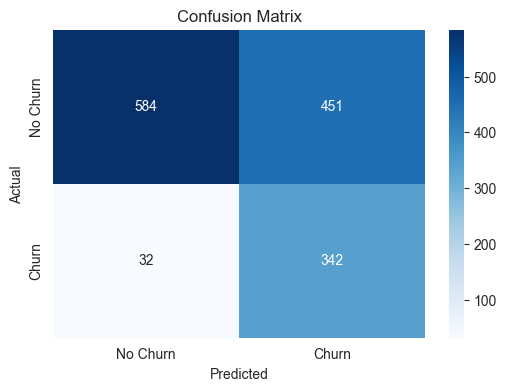

              precision    recall  f1-score   support

    No Churn       0.95      0.56      0.71      1035
       Churn       0.43      0.91      0.59       374

    accuracy                           0.66      1409
   macro avg       0.69      0.74      0.65      1409
weighted avg       0.81      0.66      0.68      1409



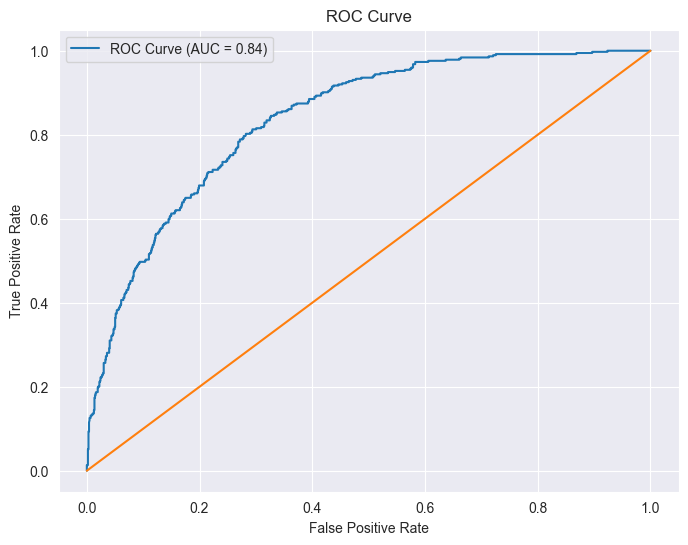

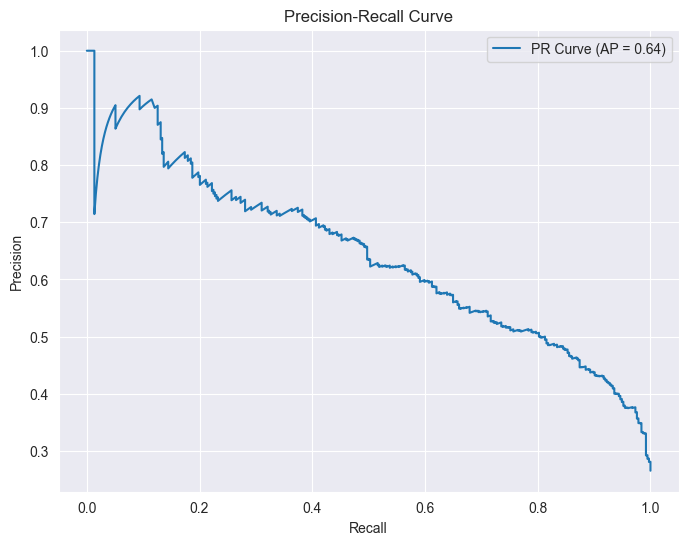

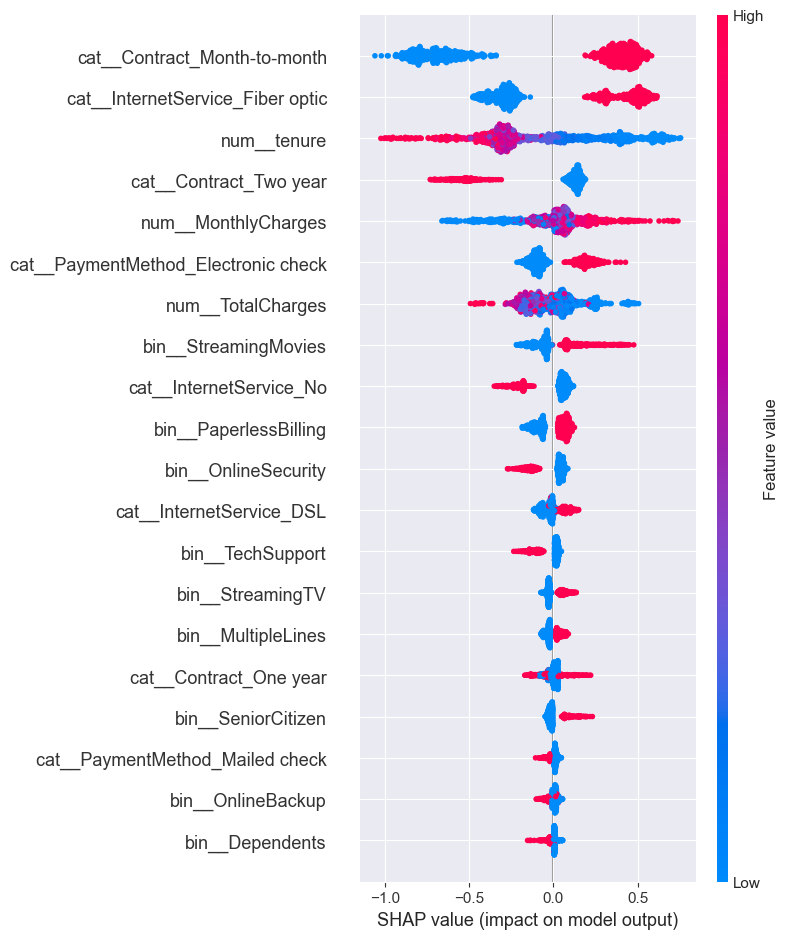

In [250]:
# define cleaned column types for the model
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
binary_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']



# build pipeline, split data, and test
pipeline = build_pipeline(numerical_cols, categorical_cols, binary_cols)


# create train and test splits
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'Yes': 1, 'No': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify=y)


# use the randomized grid search for best params
search_results = find_best_params(pipeline, X_train, y_train)
pipeline.set_params(**search_results.best_params_)

# fit the pipeline on the data
pipeline.fit(X_train, y_train)

# find the best threshold
y_probs = pipeline.predict_proba(X_test)[:, 1]
best_thresh = best_f2_thresh(y_test, y_probs)

evaluate_model(pipeline, X_test, y_test, use_cv=True, threshold=best_thresh, shap=True)


The baseline LightGBM model was tuned using randomized search and a custom threshold selected to maximize the F2 score, prioritizing recall. On the test set, it performed with an overall accuracy of 66%. The model was able to correctly identify 91% of customers who churned, indicating high recall, but with a precision of 43%, meaning that many predicted churn cases were actually non-churners. For customers who stayed, the model had a recall of 56% and a high precision of 95%. This reflects a tradeoff skewed toward capturing as many churn cases as possible, which is often prioritized when the cost of missing the chance to engage with true churners outweighs the cost of false positives.

The overall precision-recall tradeoff is limited, and the model's performance could be improved. Some common areas to consider are:

- Refining hyperparameter tuning
- Feature engineering & selection: create features that better capture customer patterns, and find and remove features that add more noise than signal
- Addressing data imbalance: use techniques beyond scale_pos_weight to address class imbalance in churn
- Alternative classifiers: experiement with classifiers like Random Forest or XGBoost, and try stacking or blending models nto ensembles to capture different signals.



In [ ]:
# model saving

import joblib
joblib.dump(pipeline, "baseline_churn_lgbm_model.joblib")